In [3]:
'''把文件生成按标签分类好的文件夹
   用于把文件生成tfrecord
'''
import numpy as np  
import struct  
  
from PIL import Image  
import os  
  
data_file = './data/fashion/t10k-images-idx3-ubyte'  #需要修改的路径  
# 所用文件的大小
data_file_size = 7840016  
data_file_size = str(data_file_size - 16) + 'B'  
  
data_buf = open(data_file, 'rb').read()  
  
magic, numImages, numRows, numColumns = struct.unpack_from('>IIII', data_buf, 0)  
# struct.unpack_from(fmt, buffer, offset=0)根据格式化字符串fmt，从位置offset开始解包。即使结果只包含一项，也是一个元组

datas = struct.unpack_from('>' + data_file_size, data_buf, struct.calcsize('>IIII'))  
# 返回对应于格式化字符串fmt的结构体（以及由pack(fmt, ...)生成的字节对象）的大小
datas = np.array(datas).astype(np.uint8).reshape(numImages, 1, numRows, numColumns)  
  
label_file = './data/fashion/t10k-labels-idx1-ubyte' #需要修改的路径  
  
# It's 60008B, but we should set to 60000B  
label_file_size = 10008  
label_file_size = str(label_file_size - 8) + 'B'  
  
label_buf = open(label_file, 'rb').read()  
  
magic, numLabels = struct.unpack_from('>II', label_buf, 0)  
labels = struct.unpack_from('>' + label_file_size, label_buf, struct.calcsize('>II'))  
labels = np.array(labels).astype(np.int64)  
  
datas_root = r'./data/test_data' #需要修改的路径  
if not os.path.exists(datas_root):  
    os.mkdir(datas_root)  
  
for i in range(10):  
    file_name = datas_root + os.sep + str(i)  #采用相应分割符号
    if not os.path.exists(file_name):  
        os.mkdir(file_name)  

for ii in range(numLabels):  
    img = Image.fromarray(datas[ii, 0, 0:28, 0:28])  
    label = labels[ii]  
    file_name = datas_root + '/' + str(label) + '/' + 'mnist_train_' + str(ii) + '.png'
    img.save(file_name)  
	#file_name = datas_root + '/' + 'mnist_train_' + str(ii)+ str(label) + '.png'  

In [4]:
'''把刚才生成的文件夹生成 tfrecord'''
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage.io as io


#%%

def get_file(file_dir):
    '''Get full image directory and corresponding labels
    Args:
        file_dir: 文件路径
    '''

    images = []
    temp = []
    for root, sub_folders, files in os.walk(file_dir):
        #其中第一个为起始路径string，第二个为起始路径下的文件夹list,第三个是起始路径下的文件list
        # 图片目录
        for name in files:
            images.append(os.path.join(root, name))
        # 10个标签文件夹
        for name in sub_folders:
            temp.append(os.path.join(root, name))
            
    # assign 10 labels based on the folder names
    labels = []        
    for one_folder in temp:        
        n_img = len(os.listdir(one_folder))
        letter = one_folder.split('/')[-1]#找到标签的名字
        #找到每一个图片对应的标签  
        if letter == '0':
            labels = np.append(labels, n_img*[0])
        elif letter == '1':
            labels = np.append(labels, n_img*[1])
        elif letter == '2':
            labels = np.append(labels, n_img*[2])
        elif letter == '3':
            labels = np.append(labels, n_img*[3])
        elif letter == '4':
            labels = np.append(labels, n_img*[4])
        elif letter == '5':
            labels = np.append(labels, n_img*[5])
        elif letter == '6':
            labels = np.append(labels, n_img*[6])
        
        elif letter == '7':
            labels = np.append(labels, n_img*[7])
        elif letter == '8':
            labels = np.append(labels, n_img*[8])
        else:
            labels = np.append(labels, n_img*[9])
    
    # shuffle
    temp = np.array([images, labels])
    temp = temp.transpose()
    np.random.shuffle(temp) #把图片打乱
    
    image_list = list(temp[:, 0])
    label_list = list(temp[:, 1])
    label_list = [int(float(i)) for i in label_list]
             
    return image_list, label_list# 图片列表 标签列表


#%%

def int64_feature(value):
    """Example 里放64个特征"""
    if not isinstance(value, list):
        value = [value]
    
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

#%%


def convert_to_tfrecord(images, labels, save_dir, name):
    '''convert all images and labels to one tfrecord file.
    Args:
        images: 列表形式的图片路径
        labels: int型列表标签
        save_dir: 存储tf文件路径
        name: tf文件名字
    
    '''
    
    filename = os.path.join(save_dir, name + '.tfrecords')
    n_samples = len(labels)
    #防止图片标签长度对应不上
    if np.shape(images)[0] != n_samples:
        raise ValueError('Images size %d does not match label size %d.' %(images.shape[0], n_samples))
    
    
    writer = tf.python_io.TFRecordWriter(filename)
    print('\nTransform start......')
    for i in np.arange(0, n_samples):
        try:
            image = io.imread(images[i])  # type(image) must be array!
            image_raw = image.tostring()
            label = int(labels[i])
            example = tf.train.Example(features=tf.train.Features(feature={
                            'label': int64_feature(label),
                            'image_raw': bytes_feature(image_raw)}))
            writer.write(example.SerializeToString())
        except IOError as e:
            print('Could not read:', images[i])
            print('error: %s' %e)
            print('Skip it!\n')
    writer.close()
    print('Transform done!')
    
test_dir = './data/test_data'#10个标签文件夹路径
save_dir = './'存储tf路径
BATCH_SIZE = 25


#Convert test data: you just need to run it ONCE !
name_test = 'test'
images, labels = get_file(test_dir)
convert_to_tfrecord(images, labels, save_dir, name_test)


Transform start......
Transform done!


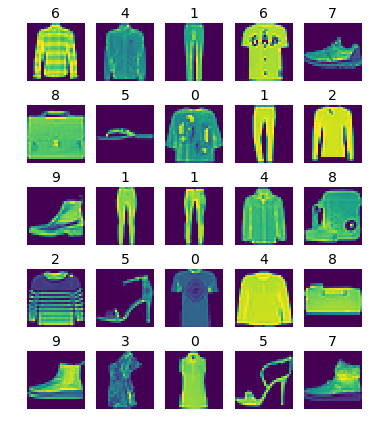

In [6]:
'''读取tf文件 
   并实现可视化'''
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage.io as io
def read_and_decode(tfrecords_file, batch_size):
    '''
    Args:
        tfrecords_file: tf文件路径
        batch_size: 需出图片的数量
    Returns:
        image: 4D tensor - [大小, 宽, 高, 几通道]
        label: 1D tensor - [大小]
    '''
    # make an input queue from the tfrecord file
    filename_queue = tf.train.string_input_producer([tfrecords_file])
    
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    img_features = tf.parse_single_example(
                                        serialized_example,
                                        features={
                                               'label': tf.FixedLenFeature([], tf.int64),
                                               'image_raw': tf.FixedLenFeature([], tf.string),
                                               })
    image = tf.decode_raw(img_features['image_raw'], tf.uint8)
    
    image = tf.reshape(image, [28, 28])
    image = tf.cast(image,tf.float32)*(1./255) #归一化
    label = tf.cast(img_features['label'], tf.int32)    
    image_batch, label_batch = tf.train.shuffle_batch([image, label], batch_size=BATCH_SIZE, capacity=2000,min_after_dequeue=50)
    return image_batch, tf.reshape(label_batch, [batch_size])

BATCH_SIZE = 25

def plot_images(images, labels):
    '''可视化
    '''
    for i in np.arange(0, BATCH_SIZE):
        plt.subplot(5, 5, i + 1)
        plt.axis('off')
        plt.title(chr(ord('0') + labels[i] ), fontsize=14)
        plt.subplots_adjust(top=1.5)
        plt.imshow(images[i]) #, cmap='gray' 变成灰色图像
    plt.show()
#以下为测试 生成test tfrecord
tfrecords_file = './test.tfrecords'
image_batch, label_batch = read_and_decode(tfrecords_file, batch_size=BATCH_SIZE)
read_and_decode(tfrecords_file,BATCH_SIZE)
with tf.Session() as sess:
    
    i = 0
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    try:
        while not coord.should_stop() and i < 1:
            # just plot one batch size            
            image, label = sess.run([image_batch, label_batch])
            plot_images(image, label)
            i += 1
            
    except tf.errors.OutOfRangeError:
        print('done!')
    finally:
        coord.request_stop()
coord.join(threads)

In [7]:
'''实现knn'''
from numpy import *  
import operator
import read  

[X_train, y_train] = read.read_and_decode('./train.tfrecords',50000)
[X_test, y_test] = read.read_and_decode('./test.tfrecords',200)
def change(X): #把数据转化为（50000，784）的形式
    s,d,f=X.shape
    b=empty((s,d*f))
    for i in range(s):
        c=X[i]
        b[i]=c.reshape(d*f)
    X=b
    return X
X_train=change(X_train)
X_test=change(X_test)

def createDataSet():  
    #对数据进行处理
    group = array(X_train)  
    labels = y_train  
    return group, labels  
    
# classify using kNN  
def kNNClassify(newInput, dataSet, labels, k):
    
    numSamples = dataSet.shape[0] # shape[0]  行数
    
    ## step 1:  计算欧式距离
    # tile(A, reps): 用来拉伸矩阵 
    
    diff = tile(newInput, (numSamples, 1)) - dataSet 
    squaredDiff = diff ** 2  
    squaredDist = sum(squaredDiff, axis = 1) #
    distance = squaredDist ** 0.5  
    
    ## step 2: 距离分类
    # argsort() 索引  
    sortedDistIndices = argsort(distance)  
    
    classCount = {} # 字典放距离近的数据
    for i in range(k):  
        ## step 3: 距离最小的几个值
        voteLabel = labels[sortedDistIndices[i]]  
    
        ## step 4: 标签出现次数 投票
        classCount[voteLabel] = classCount.get(voteLabel, 0) + 1  
    
    ## step 5: the max voted class will return  
    maxCount = 0  
    for key, value in classCount.items():  
        if value > maxCount:  
            maxCount = value  
            maxIndex = key  
        if value == 1:
            maxIndex = labels[sortedDistIndices[0]] #同票时取距离最相近的
    return maxIndex
dataSet, labels = createDataSet()  
s = 0
print('start the Knn')
# 用200数据做测试
for i in range(len(X_test)):
    testX = array(X_test[i])  
    outputLabel = kNNClassify(testX, dataSet, labels, 3)  
    if outputLabel == y_test[i]:
        s = s + 1
w = s/len(y_test)
print(w)

start the Knn
0.86


(5000, 2)
(5000, 784)
(5000,)
[[ 4.84782131  0.87927589]]


/usr/lib/python3/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


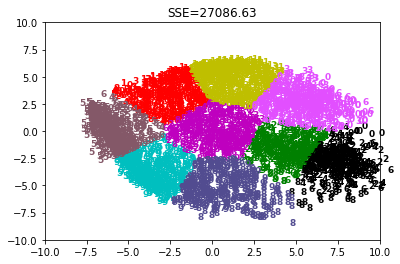

In [9]:
from sklearn import datasets
from tensorflow.examples.tutorials.mnist import input_data
import os
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
import operator  
from PIL import Image
import read  
[X, y] = read.read_and_decode('./train.tfrecords',5000)
[X_test, y_test] = read.read_and_decode('./test.tfrecords',200)
def change(X):
    s,d,f=X.shape
    b=np.empty((s,d*f))
    for i in range(s):
        c=X[i]
        b[i]=c.reshape(d*f)
    X=b
    return X
X=change(X)
X_test=change(X_test)
# X, y = input_data.read_data_sets('data/fashion').train.next_batch(50000)
def pca(data_mat, top_n_feat=99999999):
    """ 
    主成分分析：  
    输入：矩阵data_mat ，其中该矩阵中存储训练数据，每一行为一条训练数据  
         保留前n个特征top_n_feat，默认全保留
    返回降维后的数据集和原始数据被重构后的矩阵（即降维后反变换回矩阵）
    """  

    # 获取数据条数和每条的维数 
    num_data, dim = data_mat.shape  
    # print(num_data)   50000
    # print(dim)    784

    # 数据中心化，即指变量减去它的均值
    mean_vals = data_mat.mean(axis=0)   # shape:(784,)
    mean_removed = data_mat - np.tile(mean_vals, (num_data, 1))  # shape:(50000,784)
    
    # 计算协方差矩阵（Find covariance matrix）
    cov_mat = np.cov(mean_removed, rowvar=0)  # shape：(784, 784)

    # 计算特征值(Find eigenvalues and eigenvectors)
    eig_vals, eig_vects = np.linalg.eig(np.mat(cov_mat))  # 计算特征值和特征向量，shape分别为（784，）和(784, 784)

    eig_val_index = np.argsort(eig_vals)  # 对特征值进行从小到大排序，argsort返回的是索引，即下标

    eig_val_index = eig_val_index[:-(top_n_feat + 1): -1]  # 最大的前top_n_feat个特征的索引
    # 取前top_n_feat个特征后重构的特征向量矩阵reorganize eig vects, 
    # shape为(784, top_n_feat)，top_n_feat最大为特征总数
    reg_eig_vects = eig_vects[:, eig_val_index] 

    # 将数据转到新空间
    low_d_data_mat = mean_removed * reg_eig_vects  # shape: (50000, top_n_feat), top_n_feat最大为特征总数
    recon_mat = (low_d_data_mat * reg_eig_vects.T) + mean_vals  # 根据前几个特征向量重构回去的矩阵，shape:(50000, 784)

    return low_d_data_mat, recon_mat


low_d_feat_for_7_imgs, recon_mat_for_7_imgs = pca(np.array(X), 2)  # 只取最重要的2个特征
print(low_d_feat_for_7_imgs.shape)  # (50000, 2)
print(recon_mat_for_7_imgs.shape)  # (50000, 784)
print(y.shape)
print(low_d_feat_for_7_imgs[1])
X = low_d_feat_for_7_imgs
class KMeans(object):
    """
    - 参数
        n_clusters:
            聚类个数，即k
        initCent:
            质心初始化方式，可选"random"或指定一个具体的array,默认random，即随机初始化
        max_iter:
            最大迭代次数
    """
    def __init__(self,n_clusters=5,initCent='random',max_iter=300):
        if hasattr(initCent, '__array__'):
            n_clusters = initCent.shape[0]
            self.centroids = np.asarray(initCent, dtype=np.float)
        else:
            self.centroids = None
        
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.initCent = initCent
        self.clusterAssment = None
        self.labels = None   
        self.sse = None 
    
    #计算两点的欧式距离
    def _distEclud(self, vecA, vecB):
        return np.linalg.norm(vecA - vecB)
         
    # 随机选取k个质心,必须在数据集的边界内
    def _randCent(self, X, k):
        n = X.shape[1]        # 特征维数
        centroids = np.empty((k, n))  # k*n的矩阵，用于存储质心
        for j in range(n):           # 产生k个质心，一维一维地随机初始化
            minJ = min(X[:, j]) 
            rangeJ = float(max(X[:, j]) - minJ)
            centroids[:, j] = (minJ + rangeJ * np.random.rand(k, 1)).flatten()
        return centroids
        
    def fit(self, X):
        #类型检查
        if not isinstance(X, np.ndarray):
            try:
                X = np.asarray(X)
            except:
                raise TypeError("numpy.ndarray required for X")
        
        m = X.shape[0]#m代表样本数量
        self.clusterAssment = np.empty((m,2))#m*2的矩阵，第一列存储样本点所属的族的索引值，
                                               #第二列存储该点与所属族的质心的平方误差
        if self.initCent == 'random':
             self.centroids = self._randCent(X, self.n_clusters)
        
        clusterChanged = True
        for _ in range(self.max_iter):
            clusterChanged = False
            for i in range(m):#将每个样本点分配到离它最近的质心所属的族
                minDist = np.inf 
                minIndex = -1
                for j in range(self.n_clusters):
                    distJI = self._distEclud(self.centroids[j,:],X[i,:])
                    if distJI < minDist:
                        minDist = distJI; minIndex = j
                if self.clusterAssment[i,0] != minIndex:
                    clusterChanged = True
                    self.clusterAssment[i,:] = minIndex,minDist**2
                    
            if not clusterChanged:#若所有样本点所属的族都不改变,则已收敛，结束迭代
                break   
            for i in range(self.n_clusters):#更新质心，即将每个族中的点的均值作为质心
                ptsInClust = X[np.nonzero(self.clusterAssment[:,0]==i)[0]]#取出属于第i个族的所有点
                self.centroids[i,:] = np.mean(ptsInClust, axis=0)
        
        self.labels = self.clusterAssment[:,0]
        self.sse = sum(self.clusterAssment[:,1])

    
    def predict(self,X):#根据聚类结果，预测新输入数据所属的族
        #类型检查
        if not isinstance(X,np.ndarray):
            try:
                X = np.asarray(X)
            except:
                raise TypeError("numpy.ndarray required for X")
        
        m = X.shape[0]#m代表样本数量
        preds = np.empty((m,))
        for i in range(m):#将每个样本点分配到离它最近的质心所属的族
            minDist = np.inf
            for j in range(self.n_clusters):
                distJI = self._distEclud(self.centroids[j,:],X[i,:])
                if distJI < minDist:
                    minDist = distJI
                    preds[i] = j
        return preds
    
    
clf = KMeans(n_clusters=10,initCent='random',max_iter=100)
clf.fit(X)
cents = clf.centroids#质心
labels = clf.labels#样本点被分配到的簇的索引
sse = clf.sse
#画出聚类结果，每一类用一种颜色
colors = ['b','g','r','k','c','m','y','#e24fff','#524C90','#845868']
n_clusters = 10
for i in range(n_clusters):
    index = np.nonzero(labels==i)[0]
    # print(index)
    x0 = X[index,0]
    # print(x0)
    x1 = X[index,1]
    y_i = y[index]
    for j in range(len(x0)):
        plt.text(x0[j],x1[j],str(int(y_i[j])),color=colors[i],\
                fontdict={'weight': 'bold', 'size': 9})
    plt.scatter(cents[i,0],cents[i,1],marker='x',color=colors[i],linewidths=12)
plt.title("SSE={:.2f}".format(sse))
plt.axis([-10,10,-10,10])
plt.show()

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import os

mnist = input_data.read_data_sets('data/fashion', one_hot=True)
# FLAGS = tf.app.flags.FLAGS
# Basic model parameters.
my_list='/home/r/fashion-mnist/cnn'
my_cnn= 'mnist'
# tf.app.flags.DEFINE_string('my_list', '/home/r/fashion-mnist/cnn',"""存放模型的目录""")

# tf.app.flags.DEFINE_string('my_cnn', 'mnist',"""模型的名称""")


# 权值初始化
def weight_variable(shape):
    # 用正态分布来初始化权值
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    # 本例中用relu激活函数，所以用一个很小的正偏置较好
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# 定义卷积层
def conv2d(x, W):
    # 默认 strides[0]=strides[3]=1, strides[1]为x方向步长，strides[2]为y方向步长
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

# pooling 层
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


#模型文件所在的文件夹，是否存在，如果不存在，则创建文件夹
# ckpt = tf.train.latest_checkpoint(FLAGS.my_list)
ckpt = tf.train.latest_checkpoint(my_list)
if not ckpt:
    if not os.path.exists(my_list):
        os.mkdir(my_list)
X_ = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

# 把X转为卷积所需要的形式
X = tf.reshape(X_, [-1, 28, 28, 1])
# 第一层卷积：5×5×1卷积核32个 [5，5，1，32],h_conv1.shape=[-1, 28, 28, 32],学习32种特征
W_conv1 = weight_variable([5,5,1,32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(X, W_conv1) + b_conv1)

# 第一个pooling 层[-1, 28, 28, 32]->[-1, 14, 14, 32]
h_pool1 = max_pool_2x2(h_conv1)

# 第二层卷积：5×5×32卷积核64个 [5，5，32，64],h_conv2.shape=[-1, 14, 14, 64]
W_conv2 = weight_variable([5,5,32,64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

# 第二个pooling 层,[-1, 14, 14, 64]->[-1, 7, 7, 64] 
h_pool2 = max_pool_2x2(h_conv2)

# flatten层，[-1, 7, 7, 64]->[-1, 7*7*64],即每个样本得到一个7*7*64维的样本
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

# fc1
W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# dropout: 输出的维度和h_fc1一样，只是随机部分值被值为零
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# 输出层
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)


# 1.损失函数：cross_entropy
cross_entropy = -tf.reduce_sum(y_ * tf.log(y_conv))
# 2.优化函数：AdamOptimizer
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# 3.预测准确结果统计
#　预测值中最大值（１）即分类结果，是否等于原始标签中的（１）的位置。argmax()取最大值所在的下标
z = tf.argmax(y_conv, 1)
q = tf.arg_max(y_, 1)
correct_prediction = tf.equal(z, q)  
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
test_acc_sum = tf.Variable(0.0)
batch_acc = tf.placeholder(tf.float32)
new_test_acc_sum = tf.add(test_acc_sum, batch_acc)
update = tf.assign(test_acc_sum, new_test_acc_sum)
saver=tf.train.Saver(max_to_keep=2)
# 定义了变量必须要初始化，或者下面形式
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
# 或者某个变量单独初始化 如：
# x.initializer.run()
    writer = tf.summary.FileWriter(my_list,sess.graph)

    ckpt = tf.train.latest_checkpoint(my_list)
    step=0
    if ckpt:
        saver.restore(sess=sess,save_path=ckpt)
        step = int(ckpt[len(os.path.join(my_list, my_cnn)) + 1:])
    # check_point_path = '/home/r/fashion-mnist/cnn' # 保存好模型的文件路径
    # ckpt = tf.train.get_checkpoint_state(checkpoint_dir=check_point_path)
    # saver.restore(sess,ckpt.model_checkpoint_path)

#     Y = np.zeros(10000)
#     X_batch, y_batch = mnist.test.next_batch(batch_size=10000)
#     Ytemp = y_conv.eval(feed_dict={X_: X_batch, keep_prob: 1.0})
#     for i in range(10000):
#             #生成0-9标签
#         Y[i] = np.argmax(Ytemp[i])
#         # print(Y[i])
#     # print("test accuracy %g" % accuracy.eval(feed_dict={X_: X_batch, y_: y_batch, keep_prob: 1.0}))
# fp = open("test.txt", "w+")
# for i in range(10000):
#     fp.write(str(int(Y[i]))+"\n")
# fp.close()
# # 训练
#     for i in range(step,20000):
#         X_batch, y_batch = mnist.train.next_batch(batch_size=50)
#         if i % 500 == 0:
#             train_accuracy = accuracy.eval(feed_dict={X_: X_batch, y_: y_batch, keep_prob: 1.0})
#             print ("step %d, training acc %g" % (i, train_accuracy))
#             ckptname=os.path.join(FLAGS.my_list, FLAGS.my_cnn)
#             saver.save(sess,ckptname,global_step=i)
#         train_step.run(feed_dict={X_: X_batch, y_: y_batch, keep_prob: 0.5})  
    
    
# 全部训练完了再做测试，batch_size=100
    for i in range(100): 
        X_batch, y_batch = mnist.test.next_batch(batch_size=100)
        test_acc = accuracy.eval(feed_dict={X_: X_batch, y_: y_batch,
                                     keep_prob: 1.0})
        update.eval(feed_dict={batch_acc: test_acc})
        if (i+1) % 100 == 0:
            print("testing step %d, test_acc_sum %g" % (i+1, test_acc_sum.eval()))
    print(" test_accuracy %g" % (test_acc_sum.eval() / 100.0))



Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Use `argmax` instead
INFO:tensorflow:Restoring parameters from /home/r/fashion-mnist/cnn/mnist-19500
testing step 100, test_acc_sum 91.65
 test_accuracy 0.9165
